In [1]:
# Core libs
import pandas as pd
import numpy as np
import pickle

# Graphic libs
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pio.renderers.default = "browser"

# sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error as LMAPE

# IA + blockchain = profit
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Lambda, Dropout, BatchNormalization, Activation, Dense, LeakyReLU, Add
from keras.layers.merging import Add, Concatenate
from keras.utils import plot_model, to_categorical

2023-03-07 23:50:27.239094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 23:50:28.131675: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 23:50:29.422048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-07 23:50:29.422142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
SIMPLE_COLUMNS = [
    'Fecha',
    'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Distrito',
    'Estacionamiento',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Edad',
    'Elevador',
    'Conservacion',
    'Metodo',
    'AreaTerreno',
    'AreaConstruccion',
    'PromedioConstruccion',
    'PromedioTerreno',
    'Valorcomercial'
]

NUM_COLS = [
    'Fecha entrega del Informe', 
    'Tipo de vía',
    'Número de estacionamiento', #aug
    'Depósitos', #aug
    'Latitud (Decimal)', 
    'Longitud (Decimal)',
    'Número de frentes',
    'Edad', #aug
    'Elevador', 
    'Área Terreno', #aug
    'Área Construcción', #aug
    'Valor comercial (USD)',
]

CAT_COLS = [
    'Piso', #irrelevant
    'Departamento', 
    'Provincia',  
    'Distrito',  
    'Categoría del bien', 
    'Posición', #irrelevant
    'Estado de conservación', 
    'Método Representado' #irrelevant
]

TO_AUGMENT = [
    'Número de estacionamiento',
    'Depósitos',
    'Edad'
]

In [3]:
def data_sanitize_train(raw_data, train = False, region = None):

    if region is not None:
        ordinal_data = raw_data[raw_data[region[0]] == region[1]].copy()
    else:
        ordinal_data = raw_data.copy()

    for column in raw_data[:-2]:
        dist_encod = OrdinalEncoder()

        if column in CAT_COLS:
            enc = dist_encod.fit_transform(ordinal_data[[column,'ranva']].to_numpy(dtype = str))
            ordinal_data[column] = enc.T[0]

    ordinal_data = ordinal_data.drop('ranva', axis = 1)

    ordinal_data = ordinal_data.applymap(lambda x : float(x.replace(',','')) if isinstance(x,str) else x)
    ordinal_data.columns = SIMPLE_COLUMNS
    scale_data = ordinal_data.applymap(lambda x : np.cbrt(x))

    if train:
        ground_truth = ordinal_data['Valorcomercial'].to_numpy()
        return scale_data, ground_truth
    
    return scale_data

def data_sanitize_test(raw_data, augment, region=None):
    augmented_data = raw_data.copy()

    ages = augmented_data['Edad'].to_numpy()
    dates = augmented_data['Fecha entrega del Informe'].to_numpy()

    for i, age in enumerate(ages):
        if age >= 1000:
            ages[i] = np.round(((dates[i] - pd.Timestamp(ages[i])).days)/365.0)

    augmented_data['Edad'] = ages

    augmented_data.insert(augmented_data.shape[1]-2, 'Precio promedio m2 (Terreno)', np.zeros(augmented_data.shape[0]))
    augmented_data.insert(augmented_data.shape[1]-2, 'Precio promedio m2 (Construcción)', np.zeros(augmented_data.shape[0]))

    augmented_data['Área Terreno'] = augmented_data['Área Terreno'].fillna(0.0)
    augmented_data['Área Construcción'] = augmented_data['Área Construcción'].fillna(0.0)

    for dep in raw_data['Departamento'].unique():

        dep_select = raw_data[raw_data['Departamento'] == dep]
        for prov in dep_select['Provincia'].unique():

            prov_select = dep_select[dep_select['Provincia'] == prov]
            for dist in prov_select['Distrito'].unique():
                query = raw_data[(raw_data['Departamento'] == dep) &
                                 (raw_data['Provincia'] == prov  ) &
                                 (raw_data['Distrito'] == dist   )]

                fault_key = False

                for augment_dim in TO_AUGMENT:
                    to_augment_array = np.array([val.replace(',','') if isinstance(val, str) else val for val in query[augment_dim].to_list()], dtype=np.float32)

                    try:
                        to_augment_array = np.nan_to_num(to_augment_array, nan = augment[(dep,prov,dist)][augment_dim])
                    except KeyError:
                        to_augment_array = np.nan_to_num(to_augment_array, nan = 0.0)
                        fault_key = True

                    full_array = augmented_data[augment_dim].to_numpy()                    
                    full_array[query.index] = to_augment_array

                    augmented_data[augment_dim] = full_array

                if fault_key: continue
                
                avg_bval_list = augmented_data['Precio promedio m2 (Construcción)'].to_numpy()
                avg_pval_list = augmented_data['Precio promedio m2 (Terreno)'].to_numpy()
                avg_bval_list[query.index] = augment[(dep,prov,dist)]['Precio promedio m2 (Construcción)']
                avg_pval_list[query.index] = augment[(dep,prov,dist)]['Precio promedio m2 (Terreno)']
                augmented_data['Precio promedio m2 (Construcción)'] = avg_bval_list
                augmented_data['Precio promedio m2 (Terreno)'] = avg_pval_list

    return data_sanitize_train(augmented_data.applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x).fillna(-1), train=True, region=region)

def pca_plot_plotly(data, hue, n_components = -1, out = []):
    if len(out) != 0:
        data = data.drop(out, axis = 1)

    plot_pca = PCA()
    plot_pca.fit(data)
    X = data.to_numpy().T

    if n_components != -1: 
        components = (plot_pca.components_[:n_components,:]@X).T
    else: 
        components = (plot_pca.components_@X).T
    
    components_df = pd.DataFrame(components, columns=['PC'+str(i+1)+' ({:.1f})%'.format(plot_pca.explained_variance_ratio_[i]*100) for i in range(components.shape[1])])

    fig = px.scatter_matrix(components_df,
        dimensions=['PC'+str(i+1)+' ({:.1f})%'.format(plot_pca.explained_variance_ratio_[i]*100) for i in range(components.shape[1])],
        color=hue,
        title="PCA Pairs plot",
        labels=components_df.columns)
    fig.update_traces(diagonal_visible=False)
    fig.update_traces(marker_size=1)

    fig.update_layout(font=dict(size=10))

    fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False) for i in range(components.shape[1])})
    fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title='PC'+str(i+1)) for i in range(components.shape[1])})

    fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
    fig.show()

def data_plot_plotly(data, hue, out = []):
    plot_vars = []
    for var in data.columns:
        if var not in out:
            plot_vars.append(var)

    fig = px.scatter_matrix(data,
                            dimensions=plot_vars,
                            title="Scatter matrix of data set",
                            color=hue,
                            labels=plot_vars)
    fig.update_traces(diagonal_visible=False)
    fig.update_traces(marker_size=1)

    fig.update_layout(font=dict(size=10))

    try:
        fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False, title=plot_vars[i][:3].upper()) for i in range(len(plot_vars))})
        fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title=plot_vars[i][:3].upper()) for i in range(len(plot_vars))})
    except:
        pass

    fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
    fig.show()


In [4]:
augmenter = pickle.load(open('../data/xlsx/ord80p_augmentation.pkl', "rb"))
raw_data_master = pd.read_excel('../data/xlsx/ord80p_augmented.xlsx', header = [0]).applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x).fillna(-1)
raw_test_master = pd.read_excel('../data/xlsx/ord20p.xlsx', header = [0])

In [5]:
trainer_data, train_gt = data_sanitize_train(raw_data_master, True)
tester_data, test_gt = data_sanitize_test(raw_test_master, augmenter)

In [138]:
UNINTERESTING = [
    'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    #'AreaTerreno',
    #'PromedioTerreno'
]

pca_plot_plotly(trainer_data, hue = trainer_data['AreaConstruccion'], out = UNINTERESTING)

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [9]:
UNINTERESTING_A = [
    'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Distrito',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    #'AreaTerreno',
    #'PromedioTerreno'
]

UNINTERESTING_B = [
    'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    'AreaConstruccion',
    'PromedioConstruccion'
]

pca_train = trainer_data[trainer_data['AreaConstruccion'] > 0].drop(UNINTERESTING_A, axis = 1)
pca_test = tester_data[tester_data['AreaConstruccion'] > 0].drop(UNINTERESTING_A, axis = 1)

#pca_train = trainer_data.drop(UNINTERESTING_A, axis = 1)
#pca_test = tester_data.drop(UNINTERESTING_A, axis = 1)

#pca_train = trainer_data[trainer_data['AreaConstruccion'] <= 0].drop(UNINTERESTING_B, axis = 1)
#pca_test = tester_data[tester_data['AreaConstruccion'] <= 0].drop(UNINTERESTING_B, axis = 1)

#pca_plot_plotly(pca_train, hue = pca_train['Valorcomercial'], n_components=4)
pca_plot_plotly(pca_test.drop('Valorcomercial', axis = 1), hue = pca_test['Valorcomercial'])
#data_plot_plotly(pca_train, hue = pca_train['Valorcomercial'])
#data_plot_plotly(pca_test.drop('Valorcomercial', axis = 1), hue = pca_test['Valorcomercial'])

/home/ric/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [8]:
data_pca = PCA()
components = data_pca.fit_transform(pca_train)

PCA()

In [17]:
pca_train.columns

Index(['Fecha', 'Estacionamiento', 'Edad', 'Conservacion', 'AreaTerreno',
       'AreaConstruccion', 'PromedioConstruccion', 'PromedioTerreno',
       'Valorcomercial'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


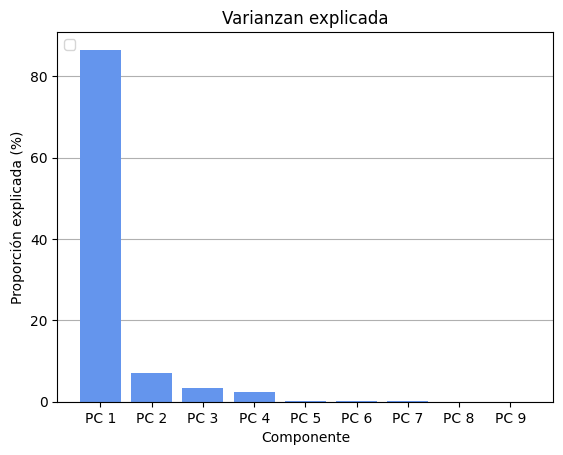

In [26]:
fig, ax = plt.subplots()

ax.set_title('Varianzan explicada')
ax.bar(range(len(data_pca.explained_variance_ratio_)),data_pca.explained_variance_ratio_*100, color='cornflowerblue')
ax.set_ylabel('Proporción explicada (%)')
ax.set_xlabel('Componente')
ax.set_xticks(range(9),['PC '+str(i+1) for i in range(9)])
ax.legend(loc='upper left')

#add horizontal gridlines behind bars in the plot
ax.set_axisbelow(True)
ax.grid(axis='y')

#display plot
plt.show()

In [262]:
pca_train.shape[1]

9

In [29]:
data_dim = pca_train.shape[1]

Xin = Input(shape=(data_dim,),name='In')

#Encoder 
#X = BatchNormalization()(Xin)
#X = Dropout(rate = 0.5)(Xin)
X = Dense(data_dim)(Xin)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)

#Code
code_rep = Dense(4, activation='tanh')(X)
CODE = Model(inputs = Xin, outputs = [code_rep], name = "Encode")

#Decoder
#X = Dropout(rate = 0.1)(code_rep)
X = Dense(data_dim)(code_rep)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
Decoded = LeakyReLU()(X)

AUTOENCODER = Model(inputs = Xin, outputs = [Decoded], name = 'Auto_encoder')

2022-12-09 03:00:54.569753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 03:00:54.888008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 03:00:54.888299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 03:00:54.889921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
AUTOENCODER.load_weights('S4D_Her0/AUTOENCODER_final.h5')

In [252]:
epochs     = 1500        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 0.001     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

AUTOENCODER.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                      loss      = 'mse',
                      metrics   = ['accuracy'])

#Jengi_train.summary()

history = AUTOENCODER.fit(x                = pca_train,
                          y                = pca_train,
                          batch_size       = batch_size,
                          epochs           = epochs,
                          validation_split = 0.2,
                          verbose          = 1)

Epoch 1/1500
31/31 [==============================] - 1s 12ms/step - loss: 10.7966 - accuracy: 0.9470 - val_loss: 2.0581 - val_accuracy: 0.9890
Epoch 2/1500
31/31 [==============================] - 0s 7ms/step - loss: 1.0649 - accuracy: 0.9941 - val_loss: 0.9960 - val_accuracy: 0.9988
Epoch 3/1500
31/31 [==============================] - 0s 6ms/step - loss: 0.7091 - accuracy: 0.9981 - val_loss: 0.8807 - val_accuracy: 0.9987
Epoch 4/1500
31/31 [==============================] - 0s 7ms/step - loss: 0.6800 - accuracy: 0.9987 - val_loss: 0.8487 - val_accuracy: 0.9988
Epoch 5/1500
31/31 [==============================] - 0s 6ms/step - loss: 0.6720 - accuracy: 0.9989 - val_loss: 0.8262 - val_accuracy: 0.9986
Epoch 6/1500
31/31 [==============================] - 0s 6ms/step - loss: 0.6684 - accuracy: 0.9988 - val_loss: 0.8126 - val_accuracy: 0.9990
Epoch 7/1500
31/31 [==============================] - 0s 8ms/step - loss: 0.6662 - accuracy: 0.9989 - val_loss: 0.7962 - val_accuracy: 0.9990
Epoc

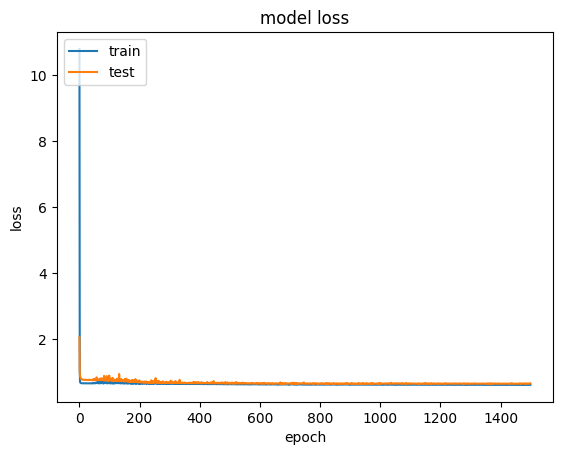

In [253]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [301]:
#AUTOENCODER.save_weights("S4D_Her0/AUTOENCODER_final.h5")

In [34]:
res = CODE.predict(pca_train)
res_df = pd.DataFrame(res)
data_plot_plotly(res_df, hue = pca_train['PromedioConstruccion'])

1194/1194 [==============================] - 1s 954us/step


In [232]:
pca_train.columns

Index(['Fecha', 'Distrito', 'Estacionamiento', 'Edad', 'Conservacion',
       'AreaTerreno', 'AreaConstruccion', 'PromedioConstruccion',
       'PromedioTerreno', 'Valorcomercial'],
      dtype='object')

In [22]:
data_plot_plotly(res_df, hue = pca_train['Fecha'])

In [306]:
fig = px.scatter_3d(
    res, x=0, y=1, z=2, color=pca_train['Valorcomercial'],
    labels={'0': 'CE 1', '1': 'CE 2', '2': 'CE 3'},
)
fig.update_traces(marker_size = 1)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [146]:
fig = px.scatter_3d(
    res, x=1, y=2, z=3, color=pca_train['PromedioConstruccion'],
    labels={'1': 'CE 2', '2': 'CE 3', '3': 'CE 4'},
)
fig.update_traces(marker_size = 1)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [205]:
#print(LMAPE(price_encoded, price_decoded))
print(pca_train[:10])
print(price_decoded[:10])

0.004905509523079617
[ 247328.  165675. 1542273.   54705.   64184.  170437.  652150.  146460.
   89383.  143374.]
[ 246879.73   165941.02  1499461.2     55063.137   64492.805  170917.39
  650554.4    146178.92    89835.25   143048.4  ]


In [263]:
X_train = pca_train.drop('Valorcomercial', axis = 1)
Y_train = CODE.predict(pca_train)

1194/1194 [==============================] - 2s 2ms/step


In [264]:
X_train.shape[1]

8

In [294]:
Xin = Input(shape=(X_train.shape[1],),name='In')
#X = Dropout(rate = 0.1)(Xin)
#X = BatchNormalization()(X)
X = Dense(10)(Xin)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
cbrt_price = Dense(1, activation='relu')(X)
CBRT_predictor = Model(inputs = Xin, outputs = [cbrt_price], name = "Predictor")

in_completed = Concatenate(axis=1, name = 'completion')([Xin,cbrt_price])
#in_completed = Add(name = 'completion')([Xin,completion])
CODE.trainable = False
Yout = CODE(in_completed)

CODE_Trainer = Model(inputs = Xin, outputs = [Yout], name = 'encode_train')

In [303]:
#CBRT_predictor.save_weights('S4D_Her0/CBRT_predictor.h5')

In [295]:
epochs     = 4500#1500        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 0.01     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

CODE_Trainer.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                       loss      = 'mae',
                       metrics   = ['accuracy'])

#Jengi_train.summary()

history = CODE_Trainer.fit(x                = X_train,
                             y                = Y_train,
                             batch_size       = batch_size,
                             epochs           = epochs,
                             validation_split = 0.2,
                             verbose          = 1)

Epoch 1/4500
31/31 [==============================] - 1s 13ms/step - loss: 0.0617 - accuracy: 0.9483 - val_loss: 0.0363 - val_accuracy: 0.9486
Epoch 2/4500
31/31 [==============================] - 0s 5ms/step - loss: 0.0324 - accuracy: 0.9517 - val_loss: 0.0296 - val_accuracy: 0.9515
Epoch 3/4500
31/31 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.9576 - val_loss: 0.0230 - val_accuracy: 0.9631
Epoch 4/4500
31/31 [==============================] - 0s 6ms/step - loss: 0.0214 - accuracy: 0.9681 - val_loss: 0.0207 - val_accuracy: 0.9682
Epoch 5/4500
31/31 [==============================] - 0s 6ms/step - loss: 0.0199 - accuracy: 0.9697 - val_loss: 0.0199 - val_accuracy: 0.9696
Epoch 6/4500
31/31 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 0.9692 - val_loss: 0.0197 - val_accuracy: 0.9686
Epoch 7/4500
31/31 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.9683 - val_loss: 0.0193 - val_accuracy: 0.9685
Epoch

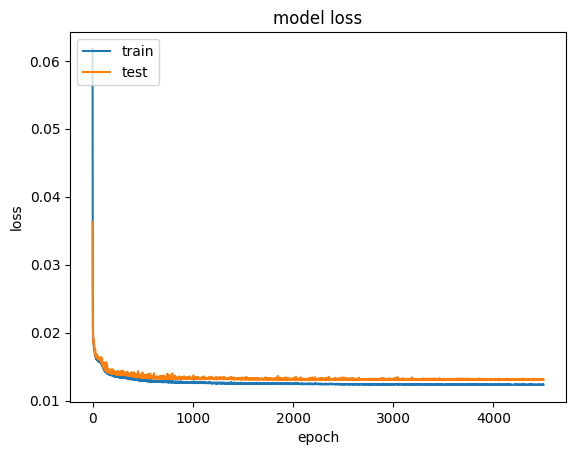

In [296]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [307]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [314]:
X_test = pca_test.drop('Valorcomercial', axis = 1)
Y_test = pca_test['Valorcomercial'].to_numpy()

res = CBRT_predictor.predict(X_test)
Y_hat = res.T[0]

299/299 [==============================] - 0s 1ms/step


In [315]:
print(MSE(Y_test, Y_hat))
print(Y_test[:10])
print(Y_hat[:10])

97.27098263270251
[ 62.77081419  54.92275658 115.53682228  51.76994027  37.9614105
  54.45567757  40.03829666  55.44400922  86.71931384  38.83493683]
[ 64.16445   50.997066 130.21823   55.78743   44.201103  59.847763
  43.053185  58.226418  85.835815  43.311752]


In [316]:
region_tester, region_test_gt = data_sanitize_test(raw_test_master, augmenter, region = ('Provincia','Lima'))
reg_test = region_tester.drop(UNINTERESTING_A, axis = 1)

X_test = reg_test.drop('Valorcomercial', axis = 1)
Y_test = reg_test['Valorcomercial'].to_numpy()

res = CBRT_predictor.predict(X_test)
Yp_hat = res.T[0]

214/214 [==============================] - 0s 1ms/step


In [317]:
print(MSE(Y_test, Yp_hat))
print(Y_test[:10])
print(Yp_hat[:10])

107.88406282911677
[ 62.77081419  54.92275658 115.53682228  37.9614105   40.03829666
  53.36803297  55.44400922  86.71931384  52.71161752  44.71140415]
[ 64.16445   50.997066 130.21823   44.201103  43.053185  51.268406
  58.226418  85.835815  52.59697   46.77117 ]


In [213]:
resp_df = pd.DataFrame(resp**3, columns = pca_test.columns)
data_plot_plotly(resp_df, hue = np.cbrt(Yp_hat))

In [212]:
Xp_df = pd.DataFrame(Xp_test, columns = pca_test.columns)
data_plot_plotly(Xp_df, hue = np.cbrt(Yp_hat))